# Survival Models

Survival models, also known as time-to-event models, are specialized statistical methods designed to analyze the time until the occurrence of an event of interest. In this notebook, a review of survival analysis  and censored data is provided, followed by a survival model implementation in Bambi.

## Survival and censoring times

Sometimes the right way to model discrete, countable events is to model not the counts themselves but rather the **time between events**. This gives us information regarding the rate of an event. Survival models are models for countable things, but the outcomes we want to predict are durations. Durations are continuous deviations from some point of reference (so they are all positive values). 

The tricky part with survival models is not the probability distribution assigned to the durations, but dealing with censoring. Censoring occurs when the event of interest does not occur in the window of observation. In a simple scenario, this can happen because the observation period ends before the event occurred. Censored individuas (or units) can not just be dropped from the sample. Imagine a cohort of 100 cats who start waiting for adoption at the same time. After one month, half of them have been adopted. Now what is the rate of adoption? You can’t compute it using only the cats who have been adopted. You need to also account for the cats who haven’t yet been adopted. The cats who haven’t been adopted yet, but eventually will be adopted, clearly have longer waiting times than the cats who have already been adopted. So the average rate among those who are already adopted is biased upwards—it is confounded by conditioning on adoption.

Including censored observations requires a new type of model. The key idea is that the same distribution assumption for the outcome tells us both the probability of any observed duration that end in the event as well as the probability that we would wait the observed duration without seeing the event. For each unit, we assume there is a true _survival time_ $T$ as well as a true censoring time $C$. The survival time represents the time at which the event of interest occurs. The censoring time is the time at which censoring occurs. We observe either: the survival, or the censoring time:

$$Y = \text{min}(T, C)$$

If the event occurs, then we observe the survival time, else we observe the censoring time. In order to analyze survival data, we first need to understand the two types of censoring: left and right censoring, and how to estimate the survival function.

## Left and right censoring

There are two main "types" of censoring: right and left. Right sensoring occurs when $T \ge Y$, i.e. the true event time $T$ is at least as large as the observed time $Y$. This is a consequence of $Y = \text{min}(T, C)$. Right censoring derives its name from the notion that time is typically read and displayed from left to right. Left sensoring occurs when the true event time $T$ is less than or equal to the observed time $Y$. An example of left censoring could be in a study of pregnancy duration, suppose that patients are surveyed 250 days (8.2 months) after conception. Some patients may have already had their babies. For these patients, pregnancy duration is **less than** 250 days.

## Estimating the survival function

Survival analysis is concerned with estimating the survival function $S(t)$

$$S(t) = Pr(T > t) = 1 - F(t)$$

which is a decreasing function that quantifies the probability of surviving past time $t$. Alternatively, $S(t)$ can be expressed as one minus the cumulative distribution function (CDF) $F$ of the event time $T$—referred to as the complementary cumulative distribution function (CCDF). The focus on the survival function is important because for censored observations, we only know that the time-to-event exceeds the observed time $Y$.

Here, continuing with the cat adoption example, we consider the task of estimating the survival function for cat adoptions. To estimate $S(30) = Pr(T > 30)$, the probability that a cat is not adopted after 30 days, it is tempting to compute the proportion of cats who were adopted before 30 days and subtract this from 1. However, this would be incorrect because it ignores the cats who were not adopted before 30 days but who **will be** adopted later—these cats clearly have longer adoption rates. Thus, if we continued with the naive approach, the average rate of adoption would be biased upwards—it is confounded by conditioning on adoption.

However, it is possible to overcome this challenge by using the Kaplan-Meier estimator. The Kaplan-Meier estimator is a non-parametric estimator of the survival function that accounts for censoring. Let $d_1 < d_2 < . . . < d_K$ denote the $K$ unique adoption times among the non-censored cats, and $q_k$ denote the number of cats adopted at time $d_k$. For $k = 1,...,K$, let $r_k$ denote the number of cats not adopted at time $d_k$. By the law of total probability

$$Pr(T > d_k) = Pr(T > d_k | T > d_{k-1}) Pr(T > d_{k-1}) + Pr(T > d_k | T \leq d_{k-1}) Pr(T \leq d_{k-1})$$

The fact that $d_{k-1} < d_k$ implies that $Pr(T > d_k | T \leq d_{k-1}) = 0$ (as it is impossible for a cat to be adopted past time $d_k$ if the cat was adopted before time $d_{k-1}$). Thus, if we simplify the above equation and plug into the survival function, we obtain

$$S(d_k) = Pr(T > d_k | T > d_{k-1})S(d_{k-1})$$

Now we must estimate the terms on the right-hand side. It is common to use the following estimator 

$$\hat{Pr}(T > d_j | T > d_{j-1}) = \frac{r_j - q_j}{r_j}$$

which leads us to the Kaplan-Meier estimator of the survival function

$$\hat{S}(d_k) = \prod_{j=1}^k \frac{r_j - q_j}{r_j}$$

where $\hat{S}(d_k)$ represents the estimated survival probability up to time $d_k$. The product is taken over all time points up to $k$, where an event occurred. The variables $r_j$ and $q_j$ denote the number of subjects at risk and the number of events at time $d_j$, respectively. The term $\frac{r_j - q_j}{r_j}$ is the conditional probability of surviving the $j$-th time point given that an individual has survived up to just before $d_j$. Specifically, $r_j - q_j$ are the number of individuals who survived up to just before $d_j$ and $r_j$ is the number of individuals who survived up to just after $d_j$, and $r_j$ are those who were at risk $d_j$.

Below is a Python function implementing the Kaplan-Meier estimator to estimate the survival function for cat adoptions.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy

import bambi as bmb

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
url = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/AustinCats.csv"
cats = pd.read_csv(url, sep=";")

cats_new = cats.copy()
cats_new["adopt"] = np.where(cats_new["out_event"] == "Adoption", "right", "none")
cats_new["color_id"] = np.where(cats_new["color"] == "Black", 1, 0)
cats_new = cats_new[["days_to_event", "adopt", "color_id"]]

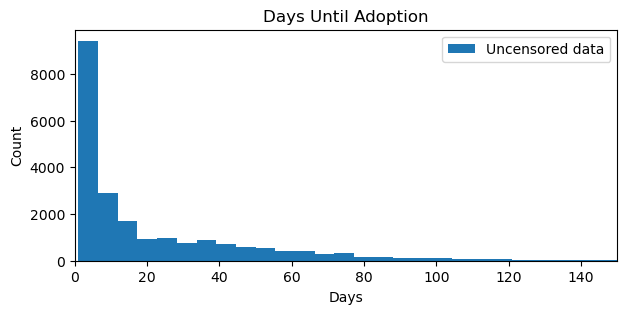

In [3]:
plt.figure(figsize=(7, 3))
plt.hist(cats_new["days_to_event"], bins=250, label="Uncensored data")
plt.xlim(0, 150) # truncate for visibility
plt.title("Days Until Adoption")
plt.ylabel("Count")
plt.xlabel("Days")
plt.legend();

In [4]:
def kaplan_meier_estimator(d_k, d, times):
    """
    Computes the Kaplan-Meier estimator.

    Parameters:
    -----------
    - d_k: np.ndarray
        Array of unique observed event times.
    - d: np.ndarray
        Array indicating if the event occurred at the time from the 'd_k' list;
        True if event occurred, False if censored.
    - times: np.ndarray
        Array of times at which the survival function should be evaluated.

    Returns:
    --------
    - List of Kaplan-Meier estimates at the specified 'times'.
    """

    n = len(d_k)
    survival = []
    s_prev = 1

    for time in times:
        product = s_prev
        for i in range(n):
            if d_k[i] <= time:
                product *= (1 - d[i] / (n - i))
        survival.append(product)
        s_prev = product

    return survival

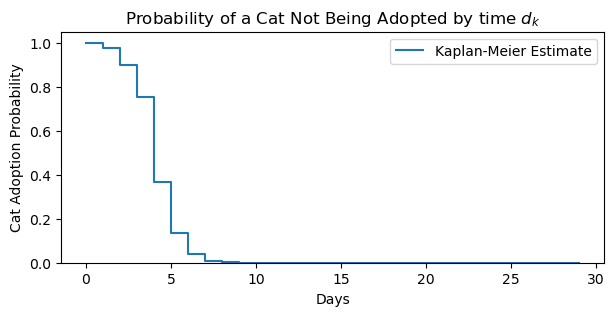

In [5]:
observed_adoption_times = cats_new[cats_new["adopt"] == "right"]["days_to_event"].values
adoption = (cats_new["adopt"] == "right").values
evaluation_times = np.arange(0, 30, 1)
adoption_km_estimates = kaplan_meier_estimator(
    observed_adoption_times, adoption, evaluation_times
)

plt.figure(figsize=(7, 3))
plt.step(evaluation_times, adoption_km_estimates, where="post", label="Kaplan-Meier Estimate")
plt.xlabel("Days")
plt.ylabel("Cat Adoption Probability")
plt.title("Probability of a Cat Not Being Adopted by time $d_k$")
plt.ylim(0, 1.05)
plt.legend()
plt.show()

## The `pm.Censored` distribution

The [censored distribution](https://www.pymc.io/projects/docs/en/latest/api/distributions/censored.html) from PyMC allows us to make use of a sequential construction, similar to the Kaplan-Meier estimator outlined above, to model censored data. To understand the `pm.Censored` distribution, lets reason how a distribution may be used to model censored data. For observed adoptions, probability of observed waiting time is distributed according to an exponential to some rate $\lambda$
$$D_i \sim \text{Exponential}(\lambda_i)$$
or
$$Pr(D_i | \lambda_i) = \lambda_i \text{exp}(-\lambda_i D_i)$$
It’s the censored cats that are tricky. If something else happened before a cat could be adopted, or it simply hasn’t been adopted yet, then we need the **probability of not being adopted, conditional on the observation time so far**. One way to motivate this is to image a cohort of 100 cats, all joining the shelter on the same day. 
- If half have been adopted after 30 days, then the probability of waiting 30 days and still not being adopted is 0.5. 
- If after 60 days, only 25 remain, then the probability of waiting 60 days and not yet being adopted is 0.25. 
- Any given rate of adoption implies a proportion of the cohort of 100 cats that will remain after any given number of days.

This probability comes from the cumulative probability distribution. A cumulative distribution gives the proportion of cats adopted before or at a certain number of days. So $1 - \text{CDF}$ gives the probability a cat is not adopted by the same number of days—also known as the complementary cumulative distribution function (CCDF). If the exponential distribution is used, the CDF is
$$Pr(D_i | \lambda_i) = 1 - \text{exp}(-\lambda_i D_i)$$

so the complement is
$$Pr(D_i | \lambda_i) = \text{exp}(-\lambda_i D_i)$$

Which is what we need in our model since it is the probability of waiting $D_i$ days without being adopted yet. The `pm.Censored` from PyMC offers a convenient way to model censored data and is defined as

\begin{cases} 
0 & \text{for } x < \text{lower}, \\
\text{CDF}(\text{lower}, \text{dist}) & \text{for } x = \text{lower}, \\
\text{PDF}(x, \text{dist}) & \text{for } \text{lower} < x < \text{upper}, \\
1 - \text{CDF}(\text{upper}, \text{dist}) & \text{for } x = \text{upper}, \\
0 & \text{for } x > \text{upper}.
\end{cases}

where lower is left-censored and upper is right-censored. Our cat adoption dataset is right-censored. Therefore, lower can be `None`, and upper is the observed times when an event occurs. The `pm.Censored` uses the CCDF to answer the question we are interested in: what is the probability of not being adopted yet, given the observation time so far?

### Implementation in Bambi

To understand how this is used, lets use Bambi to recover the parameters of the censored distribution with no predictors. Before the model is fit, `days_to_event` is scaled to represent months as the raw values contain very large values. This scaling ensures a smoother sampling process.

The `exponential` distribution is used to model the cat adoption rate parameter. But why not enter `censored` as the likelihood like we normally do in Bambi? The `pm.Censored` is indeed eventually used as the likelihood. However, there also needs to be a distribution that models the rate parameter. In this case it is the `exponential` distribution. This distribution is then used as input into the `pm.Censored` distribution. For more information on how to use the `pm.Censored` distribution, see the following PyMC documentation: [Bayesian regression models with truncated and censored data](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-truncated-censored-regression.html#run-the-truncated-and-censored-regressions) and [Censored data models](https://www.pymc.io/projects/examples/en/latest/survival_analysis/censored_data.html).

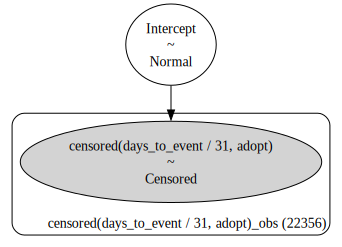

In [6]:
cat_model = bmb.Model(
    "censored(days_to_event / 31, adopt) ~ 1", 
    data=cats_new,
    family="exponential",
    link="log"
)
cat_model.build()
cat_model.graph()

In [7]:
idata = cat_model.fit(
    tune=500,
    draws=500,
    random_seed=42, 
    chains=4, 
    cores=10
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [Intercept]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 5 seconds.


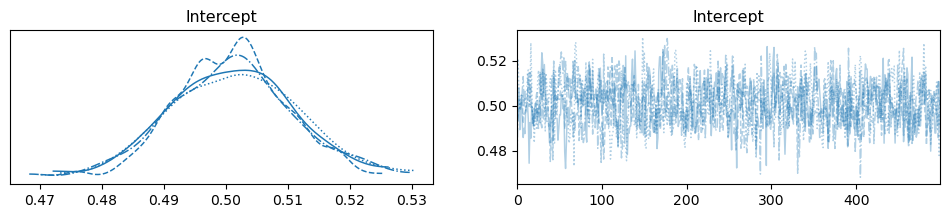

In [8]:
az.plot_trace(idata);

In [9]:
summary = az.summary(idata)
summary

/Users/gabestechschulte/miniforge3/envs/bambinos/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.501,0.01,0.483,0.52,0.0,0.0,801.0,1099.0,1.0


Interpreting the intercept (the cat adoption rate parameter) alone is of not much value. Therefore, lets use the `scipy.stats.sf` survival function to compute the probability of not being adopted after a range of months, given the learned rate parameter $\lambda$. Additionally, we will plot the average cat adoption waiting time.

### Cat adoption plots

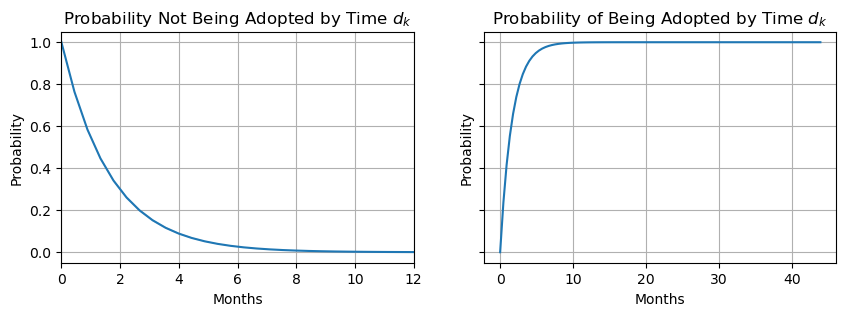

In [10]:
lambda_ = 1 / np.exp(summary["mean"]["Intercept"])
lambda_lower = 1 / np.exp(summary["hdi_3%"]["Intercept"])
lambda_upper = 1 / np.exp(summary["hdi_97%"]["Intercept"])

t = np.linspace(0, max(cats_new["days_to_event"] / 31), 100)
S0 = scipy.stats.expon.sf
cdf = scipy.stats.expon.cdf

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3), sharey=True)

ax[0].plot(t, S0(lambda_ * t))
ax[0].fill_between(t, S0(lambda_lower * t), S0(lambda_upper * t), alpha=0.25)
ax[0].grid(True)
ax[0].set_xlim(0, 12)
ax[0].set_xlabel("Months")
ax[0].set_ylabel("Probability")
ax[0].set_title("Probability Not Being Adopted by Time $d_k$")

ax[1].plot(t, cdf(lambda_ * t))
ax[1].fill_between(t, cdf(lambda_lower * t), cdf(lambda_upper * t), alpha=0.25)
ax[1].grid(True)
ax[1].vlines(1, 1, 1, linestyles="dashed")
ax[1].set_xlabel("Months")
ax[1].set_ylabel("Probability")
ax[1].set_title("Probability of Being Adopted by Time $d_k$");

Analyzing the CCDF (the left plot), the probability of a cat waiting one month without being adopted is about $0.60$, whereas the probability of a cat being adopted by the first month is about $0.40$. Analyzing the CDF (right plot), the majority of cats, about $0.97$, are adopted by the sixth month. Now that we have an intuition on how `pm.Censored` is used for modeling censored data, in the next section, we will discuss on how to model censored data with predictors. 

## Regression models with a survival response

It is often the case that we would like to understand how various predictors are associated with the survival function. For example, we may want to know if the survival function for cats of different colors or species is different. As outlined above, we cannot simply run a regression on the observed times $Y$ given some predictors $X$. What we are actually interested in is predicting the survival time $T$ given the predictors $X$. To achieve this, we first need to understand the Hazard function and the Cox proportional hazards model.

**TO DO: the two sections below need finished. Do we need them? The pm.Censored distribution does most of the work.**

### The hazard function

In survival analysis, it is often more convenient to express the survival function in terms of the hazards rate which is the instantaneous rate of an event occuring at time $t$ given that the event has not yet occured.

\begin{split}\begin{align*}
\lambda(t)
    & = \lim_{\Delta t \to 0} \frac{P(t < T < t + \Delta t\ |\ T > t)}{\Delta t} \\
    & = \lim_{\Delta t \to 0} \frac{P(t < T < t + \Delta t)}{\Delta t \cdot P(T > t)} \\
    & = \frac{1}{S(t)} \cdot \lim_{\Delta t \to 0} \frac{S(t) - S(t + \Delta t)}{\Delta t}
      = -\frac{S'(t)}{S(t)}.
\end{align*}\end{split}


where $T$ is the (unobserved) survival time. The Hazard function is closely related to the survival function $S(t)$, and it is a key approach for modeling survival data as a function of predictors.



However, it is typical to phrase the model in terms of the cumulative hazard function

$$\Lambda(t) = -\text{log} S(t)$$


### The Cox proportional hazards model

Above, we developed a model with no predictors to recover the parameters of the cat adoption rate, and used this as input into the `pm.Censored` distribution. Since we would now like to add predictor(s), we need to reformulate our modeling task into a risk regression model as it allows us to model the hazard rate as a function of our predictors. Specifically, the Cox proportional hazards model. With predictors $X$ and regression coefficients $\beta$, the hazard rate is modeled as

$$\lambda(t) = \lambda_0(t)\text{exp}(X\beta)$$

## Implementation in Bambi

Adding predictors to model the hazard rate as a function of our predictors is trivial in Bambi. We simply continue to use the formula syntax. In the backend, the rate is modeled as a function of the specified predictors in the Bambi model. For example, if in the Bambi model, we specified `censored(y, event) ~ 1 + x` with a Gaussian likelihood, then the latent rate $\lambda$ is modeled as a Gaussian distribution with mean and sigma according to

$$\alpha \sim \mathcal{N}(0, 1)$$
$$\sigma \sim \mathcal{HN}(1)$$
$$\mu = \alpha + \beta X$$
$$\lambda \sim \mathcal{N}(\mu, \sigma)$$

where $\lambda$ is then used as input into the `dist` argument of the `pm.Censored` distribution.

### Cat adoption rates by color

However, thanks to Bambi's formula syntax abstraction, we can just drop in the predictors of interest. Below, `color_id` is added to model the survival probability of black and other colored cats.

/Users/gabestechschulte/miniforge3/envs/bambinos/lib/python3.11/site-packages/formulae/terms/variable.py:87: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_string_dtype(x) or is_categorical_dtype(x):


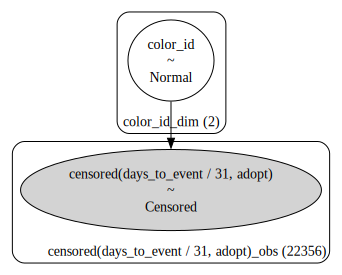

In [11]:
cat_model = bmb.Model(
    "censored(days_to_event / 31, adopt) ~ 0 + color_id", 
    data=cats_new,
    center_predictors=False,
    priors={"color_id": bmb.Prior("Normal", mu=0, sigma=1)},
    categorical=["color_id"],
    family="exponential",
    link="log"
)
cat_model.build()
cat_model.graph()

In [12]:
idata = cat_model.fit(
    tune=500,
    draws=500,
    random_seed=42, 
    chains=4, 
    cores=10
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [color_id]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 802 seconds.


In [13]:
az.summary(idata)

/Users/gabestechschulte/miniforge3/envs/bambinos/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
color_id[0],0.490,0.011,0.471,0.511,0.000,0.0,2072.0,1445.0,1.0
color_id[1],0.568,0.026,0.521,0.618,0.001,0.0,2098.0,1652.0,1.0


### Cat adoption plots

In [14]:
new_data = pd.DataFrame({"color_id": [0, 1]})
cat_model.predict(idata, data=new_data, kind="mean")

/Users/gabestechschulte/miniforge3/envs/bambinos/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [23]:
idata["posterior"]["color_id"].sel({"color_id_dim": "0"})

<xarray.DataArray 'color_id' (chain: 4, draw: 500)>
array([[0.50772912, 0.47939417, 0.49384456, ..., 0.47360753, 0.48089271,
        0.4955825 ],
       [0.49507276, 0.49628019, 0.48810001, ..., 0.48728903, 0.47357827,
        0.48218436],
       [0.49233721, 0.49097656, 0.48566468, ..., 0.48191721, 0.49245306,
        0.47481999],
       [0.50316596, 0.50316596, 0.48809324, ..., 0.50259443, 0.47684315,
        0.5004265 ]])
Coordinates:
  * chain         (chain) int64 0 1 2 3
  * draw          (draw) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
    color_id_dim  <U1 '0'

In [26]:
1 / (idata["posterior"]["censored(days_to_event / 31, adopt)_mean"]
              .sel({"censored(days_to_event / 31, adopt)_obs": 0}))

<xarray.DataArray 'censored(days_to_event / 31, adopt)_mean' (chain: 4,
                                                              draw: 500)>
array([[0.60186078, 0.61915839, 0.61027563, ..., 0.62275162, 0.61823125,
        0.60921593],
       [0.60952656, 0.60879104, 0.61379148, ..., 0.61428946, 0.62276984,
        0.61743322],
       [0.61119623, 0.61202842, 0.61528809, ..., 0.61759819, 0.61112543,
        0.62199701],
       [0.60461344, 0.60461344, 0.61379564, ..., 0.6049591 , 0.62073989,
        0.60627203]])
Coordinates:
  * chain                                    (chain) int64 0 1 2 3
  * draw                                     (draw) int64 0 1 2 ... 497 498 499
    censored(days_to_event / 31, adopt)_obs  int64 0

In [33]:
other_cats = (idata["posterior"]["color_id"].sel({"color_id_dim": "0"})
              .values
              .flatten()
              )
other_cats_preds = np.quantile(other_cats, [0.025, 0.5, 0.975])

black_cats = (idata["posterior"]["color_id"].sel({"color_id_dim": "1"})
                    .values.
                    flatten()
                    )
black_cats_preds = np.quantile(black_cats, [0.025, 0.5, 0.975])

lambdas = {
        "Other cats": other_cats_preds,
        "Black cats": black_cats_preds
        }

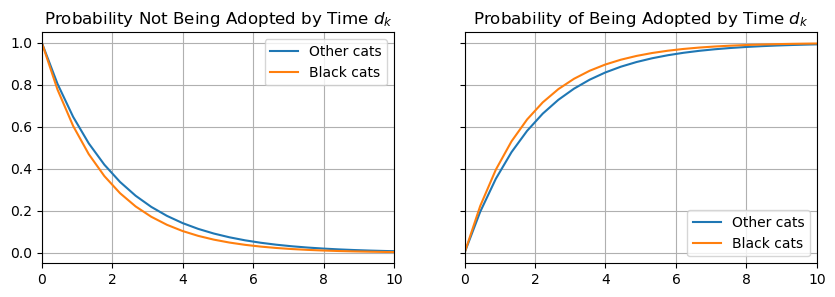

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3), sharey=True)

for key, value in lambdas.items():
    lower, median, upper = value
    ax[0].plot(t, S0(median * t), label=f"{key}")

ax[0].grid(True)
ax[0].set_xlim(0, 10)
ax[0].legend()
ax[0].set_title("Probability Not Being Adopted by Time $d_k$")

for key, value in lambdas.items():
    lower, median, upper = value
    ax[1].plot(t, cdf(median * t), label=f"{key}")

ax[1].grid(True)
ax[1].set_xlim(0, 10)
ax[1].legend()
ax[1].set_title("Probability of Being Adopted by Time $d_k$");

In [31]:
other_cats = (idata["posterior"]["censored(days_to_event / 31, adopt)_mean"]
              .sel({"censored(days_to_event / 31, adopt)_obs": 0})
              .values
              .flatten()
              )
other_cats_preds = np.quantile(other_cats, [0.025, 0.5, 0.975])

black_cats = (idata["posterior"]["censored(days_to_event / 31, adopt)_mean"]
                    .sel({"censored(days_to_event / 31, adopt)_obs": 1})
                    .values.
                    flatten()
                    )
black_cats_preds = np.quantile(black_cats, [0.025, 0.5, 0.975])

lambdas = {
        "Other cats": other_cats_preds,
        "Black cats": black_cats_preds
        }

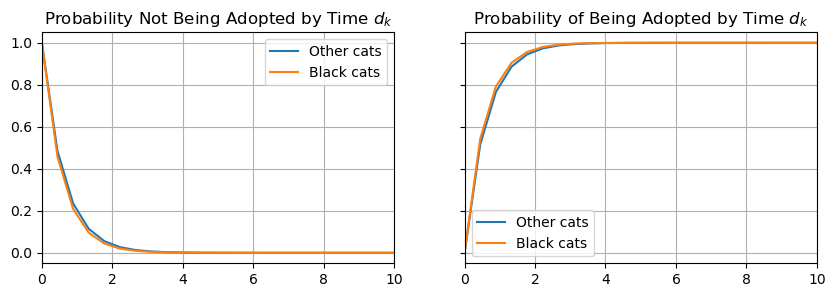

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3), sharey=True)

for key, value in lambdas.items():
    lower, median, upper = value
    ax[0].plot(t, S0(median * t), label=f"{key}")

ax[0].grid(True)
ax[0].set_xlim(0, 10)
ax[0].legend()
ax[0].set_title("Probability Not Being Adopted by Time $d_k$")

for key, value in lambdas.items():
    lower, median, upper = value
    ax[1].plot(t, cdf(median * t), label=f"{key}")

ax[1].grid(True)
ax[1].set_xlim(0, 10)
ax[1].legend()
ax[1].set_title("Probability of Being Adopted by Time $d_k$");

Analyzing the CCDF (left plot), we can see that black cats have a slightly higher probability of not being adopted throughout the whole range of $k$. Furthermore, analyzing the CDF (right plot), we can see it also takes a longer time for the majority of black cats to be adopted compared to other colored cats. Below, we plot the distribution of days until adoption for the two groups.

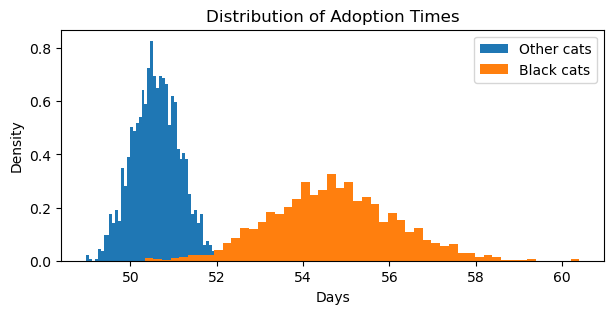

In [233]:
plt.figure(figsize=(7, 3))
plt.hist(
    other_cats * 31, 
    bins=50, 
    density=True,
    label="Other cats"
)
plt.hist(
    black_cats * 31, 
    bins=50,
    density=True,
    label="Black cats"
)
plt.legend()
plt.xlabel("Days")
plt.ylabel("Density")
plt.title("Distribution of Adoption Times");

Scaling adoption times back to days, we can see that black cats have longer and a wider range of time until adoptions (about 55 days) than cats that are not black (about 51 days).

## PyMC implementation

**TO BE REMOVED**

In [86]:
d = cats_new.reset_index(drop=True).copy()
d["adopt"] = np.where(d["adopt"] == "right", 1, 0)

dat = {
    'days_to_event': d['days_to_event'].values.astype(np.int64) / 31,
    'color_id': d['color_id'].values.astype(np.int64),
    'adopted': d['adopt'].values.astype(np.int64)
}
dat

{'days_to_event': array([0.03225806, 0.80645161, 0.12903226, ..., 0.19354839, 0.29032258,
        0.19354839]),
 'color_id': array([0, 0, 0, ..., 0, 0, 0]),
 'adopted': array([0, 0, 1, ..., 0, 0, 0])}

In [87]:
color_code = dat["color_id"]

with pm.Model() as model:

    a = pm.Normal("a", mu=0, sigma=1, shape=2)

    mu = pm.math.exp(a[color_code])
    lam = 1.0 / mu

    upper_bound = np.where(dat["adopted"] == 1, dat["days_to_event"], np.inf)
    obs = pm.Censored(
        "obs",
        dist=pm.Exponential.dist(lam=lam),
        lower=None,
        upper=upper_bound, # right-censored
        observed=dat["days_to_event"]
    )

In [88]:
with model:
    trace = pm.sample(chains=4, return_inferencedata=True, cores=10)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


In [90]:
# Get lambda, after the model is fitted so we get only the two values that are possible
trace.posterior["lam"] = 1 / np.exp(trace.posterior["a"])

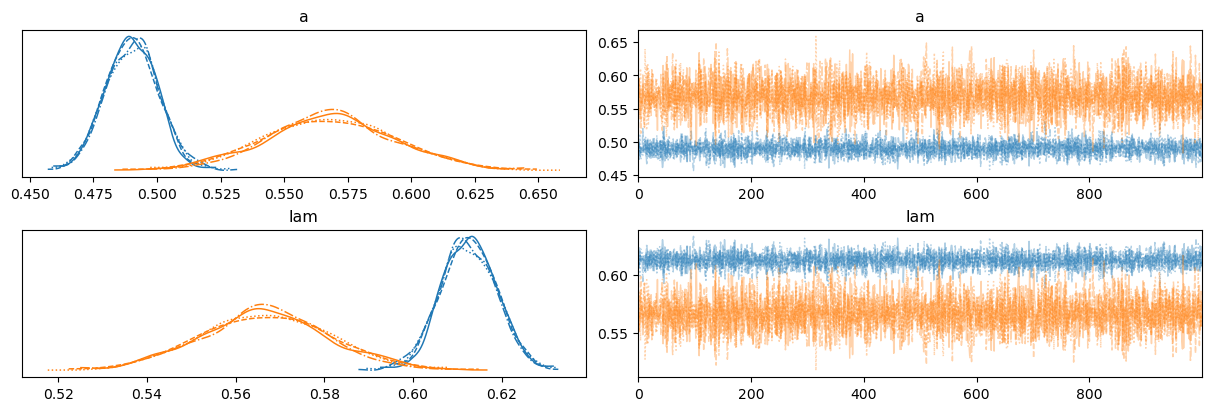

In [91]:
az.plot_trace(trace, backend_kwargs={"layout": "constrained"});

In [93]:
pymc_summary = az.summary(trace)
pymc_summary

/Users/gabestechschulte/miniforge3/envs/bambinos/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],0.490,0.010,0.471,0.509,0.0,0.0,4622.0,3179.0,1.0
a[1],0.568,0.026,0.521,0.618,0.0,0.0,4292.0,2663.0,1.0
lam[0],0.613,0.006,0.601,0.624,0.0,0.0,4622.0,3179.0,1.0
lam[1],0.567,0.014,0.539,0.593,0.0,0.0,4292.0,2663.0,1.0


In [118]:
lambda_0 = 1 / np.exp(pymc_summary["mean"]["a[0]"])
lambda_1 = 1 / np.exp(pymc_summary["mean"]["a[1]"])
lambs = [lambda_0, lambda_1]

lambda_lower_0 = 1 / np.exp(pymc_summary["hdi_3%"]["a[0]"])
lambda_upper_0 = 1 / np.exp(pymc_summary["hdi_97%"]["a[0]"])

lambda_lower_1 = 1 / np.exp(pymc_summary["hdi_3%"]["a[1]"])
lambda_upper_1 = 1 / np.exp(pymc_summary["hdi_97%"]["a[1]"])

t = np.linspace(0, max(cats_new["days_to_event"] / 31))
S0 = scipy.stats.expon.sf
cdf = scipy.stats.expon.cdf

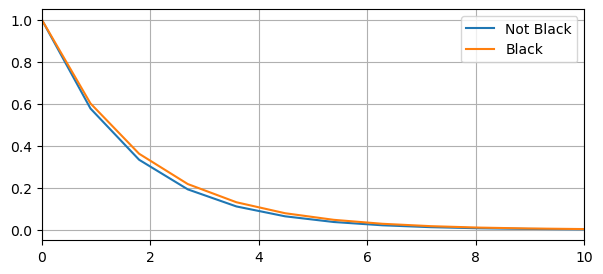

In [117]:
plt.figure(figsize=(7, 3))
for lamb, label in zip(lambs, ["Not Black", "Black"]): 
    plt.plot(t, S0(lamb * t), label=f"{label}")
    # plt.fill_between(t, S0(lambda_lower * t), S0(lambda_upper * t), alpha=0.25)
    plt.grid(True)
    plt.xlim(0, 10)

plt.legend();

In [188]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sat Oct 21 2023

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.13.2

numpy     : 1.24.2
matplotlib: 3.7.1
pandas    : 2.1.0
pymc      : 5.8.1
scipy     : 1.11.2
arviz     : 0.16.1
bambi     : 0.13.0.dev0

Watermark: 2.3.1

